## シーケンスデータ

In [ ]:
import numpy as np

def reweight_distribution(original_distribution, temperature=0.5):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)

In [ ]:
num = 5
a = np.array([0.1, 0.2, 0.3, 0.4])
a

array([0.1, 0.2, 0.3, 0.4])

In [ ]:
# 温度が低いと、ランダム性が低くなり、最も確率大きいのだけ選ばれる
reweight_distribution(a, temperature = 0.01)

array([6.22301528e-61, 7.88860905e-31, 3.20720219e-13, 1.00000000e+00])

In [ ]:
# 温度が高いと、ランダム性が高くなり、いろんな分布が選ばれるようになる
reweight_distribution(a, temperature = 300)

array([0.24933841, 0.24991517, 0.25025317, 0.25049326])

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2022-04-17 13:01:48--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  56.4MB/s    in 1.4s    

2022-04-17 13:01:49 (56.4 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
import tensorflow as tf
from tensorflow import keras

dataset = keras.utils.text_dataset_from_directory(directory="aclImdb",
                                                  label_mode=None,
                                                  batch_size=256)

dataset = dataset.map(lambda x: tf.strings.regex_replace(x, "<br />", " "))

Found 100006 files belonging to 1 classes.


In [ ]:
from tensorflow.keras.layers import TextVectorization

sequence_length = 100

# 最頻出の 15000 単語だけを考慮し、それ以外は全て OOV トークン"[UNK]"として処理
vocab_size = 15000

text_vectorization = TextVectorization(max_tokens=vocab_size,
                                       output_mode="int",
                                       output_sequence_length=sequence_length)

text_vectorization.adapt(dataset)

In [ ]:
def prepare_lm_dataset(text_batch):
    vectorized_sequences = text_vectorization(text_batch)

    # シーケンスの最後の単語を切り捨てて入力値を作成
    x = vectorized_sequences[:, :-1]
    # シーケンスのオフセットを１にして目的値を作成
    y = vectorized_sequences[:, 1:]
    return x, y

lm_dataset = dataset.map(prepare_lm_dataset, num_parallel_calls=4)

## DeepDream

450560/440742 [==============================] - 0s 1us/step


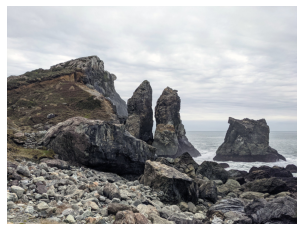

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

In [ ]:
# 訓練済みの Inception V3 モデルをインスタンス化
from tensorflow.keras.applications import inception_v3

model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}

outputs_dict = dict([
    (layer.name, layer.output)
    for layer in [model.get_layer(name) for name in layer_settings.keys()]
])

# 各ターゲット層の活性化の値を（dict として）返すモデル
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [ ]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]

        # 境界効果を回避するために非境界ピクセルだけを loss に適用
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

In [ ]:
@tf.function
def gradient_ascent_step(image, learning_rate):

    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads) # 勾配を正則化
    image += learning_rate * grads
    return loss, image

# 指定された画像の尺度（オクターブ）で勾配上昇法を実行
def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):

    # DeepDream の損失値が大きくなるように画像を繰り返し更新
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)

        # 最適化しすぎると画像に余計な加工が施されるため、それを防ぐ
        if max_loss is not None and loss > max_loss:
            break
        # print(f"... loss value at step {i}: {loss:.2f}")
    return image

In [ ]:
# params
step = 20
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15

In [ ]:
# 画像処理ユーティリティ

# サイズを変更し、適切な配列に変換
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

# NumPy 配列を有効な画像に変換
def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))

    # Inception v3 の前処理をもとに戻す
    img /= 2.0
    img += 0.5
    img *= 255.

    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [ ]:
# 画像を拡大するために多くのディテールが失われるのを避けるために、
# 失われたディテールを画像に再注入する！

original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

# 複数のオクターブで画像の目的の形状を計算
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

# 画像をコピー
img = tf.identity(original_img)

for i, shape in enumerate(successive_shapes):
    # print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )

    # 元の画像を縮小したものを拡大：画像が画素化
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)

    # このサイズでの元の画像の高品質バージョンを計算
    same_size_original = tf.image.resize(original_img, shape)

    # これら２つの差が拡大時に失われるディテールの量
    lost_detail = same_size_original - upscaled_shrunk_original_img

    # 失われたディテールをドリーム画像に再注入
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

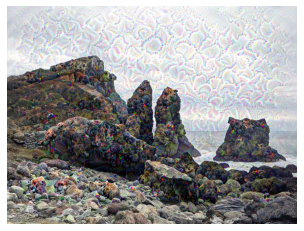

In [ ]:
deep_dream_img = keras.utils.load_img("dream.png")

plt.axis("off")
plt.imshow(deep_dream_img)
plt.show()

## ニューラルスタイル変換


In [1]:
from tensorflow import keras

# 変換したい画像
base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg"
)
# スタイル画像
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg",
    origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg"
)

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

958464/943128 [==============================] - 0s 0us/step


In [2]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))

    # ImageNet からピクセルの平均値を削除することにより中心を 0 に設定
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68

    # 画像を BGR から RGB に変換。
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [3]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# 全てのターゲット層の活性化の値を dict として返すモデル
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80150528/80134624 [==============================] - 1s 0us/step


In [4]:
import tensorflow as tf

def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

In [6]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(
        tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [7]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] -
        x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] -
        x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [8]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())

    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )

    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
            style_reference_features, combination_features
        )
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [10]:
@tf.function
def compute_loss_and_grads(
    combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(
            combination_image, base_image, style_reference_image
        )
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)

combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )

    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

Iteration 100: loss=8136.79
Iteration 200: loss=6652.43
Iteration 300: loss=6062.89
Iteration 400: loss=5741.69
Iteration 500: loss=5535.37
Iteration 600: loss=5389.80
Iteration 700: loss=5280.51
Iteration 800: loss=5194.97
Iteration 900: loss=5125.69
Iteration 1000: loss=5068.65
Iteration 1100: loss=5020.80
Iteration 1200: loss=4979.98
Iteration 1300: loss=4944.68
Iteration 1400: loss=4913.88
Iteration 1500: loss=4886.72
Iteration 1600: loss=4862.55
Iteration 1700: loss=4840.96
Iteration 1800: loss=4821.62
Iteration 1900: loss=4804.15
Iteration 2000: loss=4788.28
Iteration 2100: loss=4773.86
Iteration 2200: loss=4760.75
Iteration 2300: loss=4748.78
Iteration 2400: loss=4737.70
Iteration 2500: loss=4727.45
Iteration 2600: loss=4717.99
Iteration 2700: loss=4709.21
Iteration 2800: loss=4701.06
Iteration 2900: loss=4693.51
Iteration 3000: loss=4686.48
Iteration 3100: loss=4679.91
Iteration 3200: loss=4673.77
Iteration 3300: loss=4668.03
Iteration 3400: loss=4662.65
Iteration 3500: loss=46

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


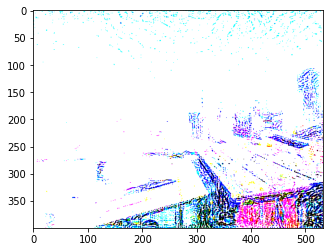

In [18]:
import matplotlib.pyplot as plt

img = keras.utils.load_img("combination_image_at_iteration_3000.png", grayscale=False, color_mode='rgb')
img = keras.utils.img_to_array(img)
plt.imshow(img)